<a href="https://colab.research.google.com/github/kimjh0607/Deep_Learning/blob/main/ViT_GPT2_ImageCaption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.4 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from timm import create_model, list_models
from types import SimpleNamespace
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, get_linear_schedule_with_warmup
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler, autocast
from tqdm.auto import tqdm
import gc
import json

from nltk.translate.bleu_score import corpus_bleu
from tqdm.auto import tqdm

In [ ]:
%env TOKENIZERS_PARALLELISM = false

env: TOKENIZERS_PARALLELISM=false


In [ ]:
sample_tfms = [
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.ColorJitter(),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.3, rotate_limit=45, p=0.5),
    A.HueSaturationValue(p=0.3),
]
train_tfms = A.Compose([
    *sample_tfms,
    A.Resize(224,224),
    A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5],always_apply=True),
    ToTensorV2()
])
valid_tfms = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5],always_apply=True),
    ToTensorV2()
])

In [ ]:
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

'<|endoftext|>'

In [ ]:
tokenizer.encode_plus('hello! this is a caption')

{'input_ids': [31373, 0, 428, 318, 257, 8305], 'attention_mask': [1, 1, 1, 1, 1, 1]}

# Dataset 불러오기

In [ ]:
!pip install kaggle --quiet

In [ ]:
# !pip install torchtext==0.6.0

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/ColabNotebooks/credential/kaggle.json'

!mkdir ~/.kaggle
!cp {path} ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# from kaggle.api.dataset import Dataset

# dataset = Dataset.load_dataset('eeshawn/flickr30k')

# dataset.download_files('/content')

In [ ]:
# !kaggle datasets download -d aladdinpersson/flickr8kimagescaptions
!kaggle datasets download -d eeshawn/flickr30k

100% 4.08G/4.08G [01:41<00:00, 45.1MB/s]
100% 4.08G/4.08G [01:41<00:00, 43.2MB/s]


In [ ]:
import zipfile
zip_file = "flickr30k.zip"
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall("dataset")
print("Unzipped the dataset.")
drive.flush_and_unmount()
print("Google Drive unmounted.")

Unzipped the dataset.
Google Drive unmounted.


In [ ]:
# caption_file_path = '/content/dataset/captions.txt'

# with open(caption_file_path, 'r') as file:
#     lines = file.readlines()

# data = []

# for line in lines:
#     image_name, caption = line.split(',', 1)
#     data.append({'image': image_name.strip(), 'caption': caption.strip().split(',',1)[1]})

# df = pd.DataFrame(data)
# df = df.drop(0).reset_index(drop=True)
# print(df.shape)
# df.head()

---

In [ ]:
class Dataset:
    def __init__(self, df, tfms):
        self.df = df
        self.tfms = tfms
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        sample = self.df.iloc[idx,:]
        image = sample['image']
        caption = sample['caption']
        image = Image.open(image).convert('RGB')
        image = np.array(image)
        augs = self.tfms(image=image)
        image = augs['image']
        caption = f"{caption}<|endoftext|>"
        input_ids = tokenizer(
            caption,
            truncation=True)['input_ids']
        labels = input_ids.copy()
        labels[:-1] = input_ids[1:]
        return image,input_ids,labels

In [ ]:
# flickr30k
base_path = Path('/content/dataset/flickr30k_images')
df = pd.read_csv('/content/dataset/captions.txt',delimiter=',')
df.rename({'image_name':'image','comment': 'caption'},inplace=True,axis=1)
df['image'] = df['image'].map(lambda x:base_path / x.strip())
df['caption'] = df['caption'].map(lambda x:x.strip().lower())
df.head()

image  comment_number  \
0  /content/dataset/flickr30k_images/1000092795.jpg               0   
1  /content/dataset/flickr30k_images/1000092795.jpg               1   
2  /content/dataset/flickr30k_images/1000092795.jpg               2   
3  /content/dataset/flickr30k_images/1000092795.jpg               3   
4  /content/dataset/flickr30k_images/1000092795.jpg               4   

                                             caption  
0  two young guys with shaggy hair look at their ...  
1  two young  white males are outside near many b...  
2   two men in green shirts are standing in a yard .  
3       a man in a blue shirt standing in a garden .  
4            two friends enjoy time spent together .

In [ ]:
df = df.drop('comment_number', axis=1)
df.head()

image  \
0  /content/dataset/flickr30k_images/1000092795.jpg   
1  /content/dataset/flickr30k_images/1000092795.jpg   
2  /content/dataset/flickr30k_images/1000092795.jpg   
3  /content/dataset/flickr30k_images/1000092795.jpg   
4  /content/dataset/flickr30k_images/1000092795.jpg   

                                             caption  
0  two young guys with shaggy hair look at their ...  
1  two young  white males are outside near many b...  
2   two men in green shirts are standing in a yard .  
3       a man in a blue shirt standing in a garden .  
4            two friends enjoy time spent together .

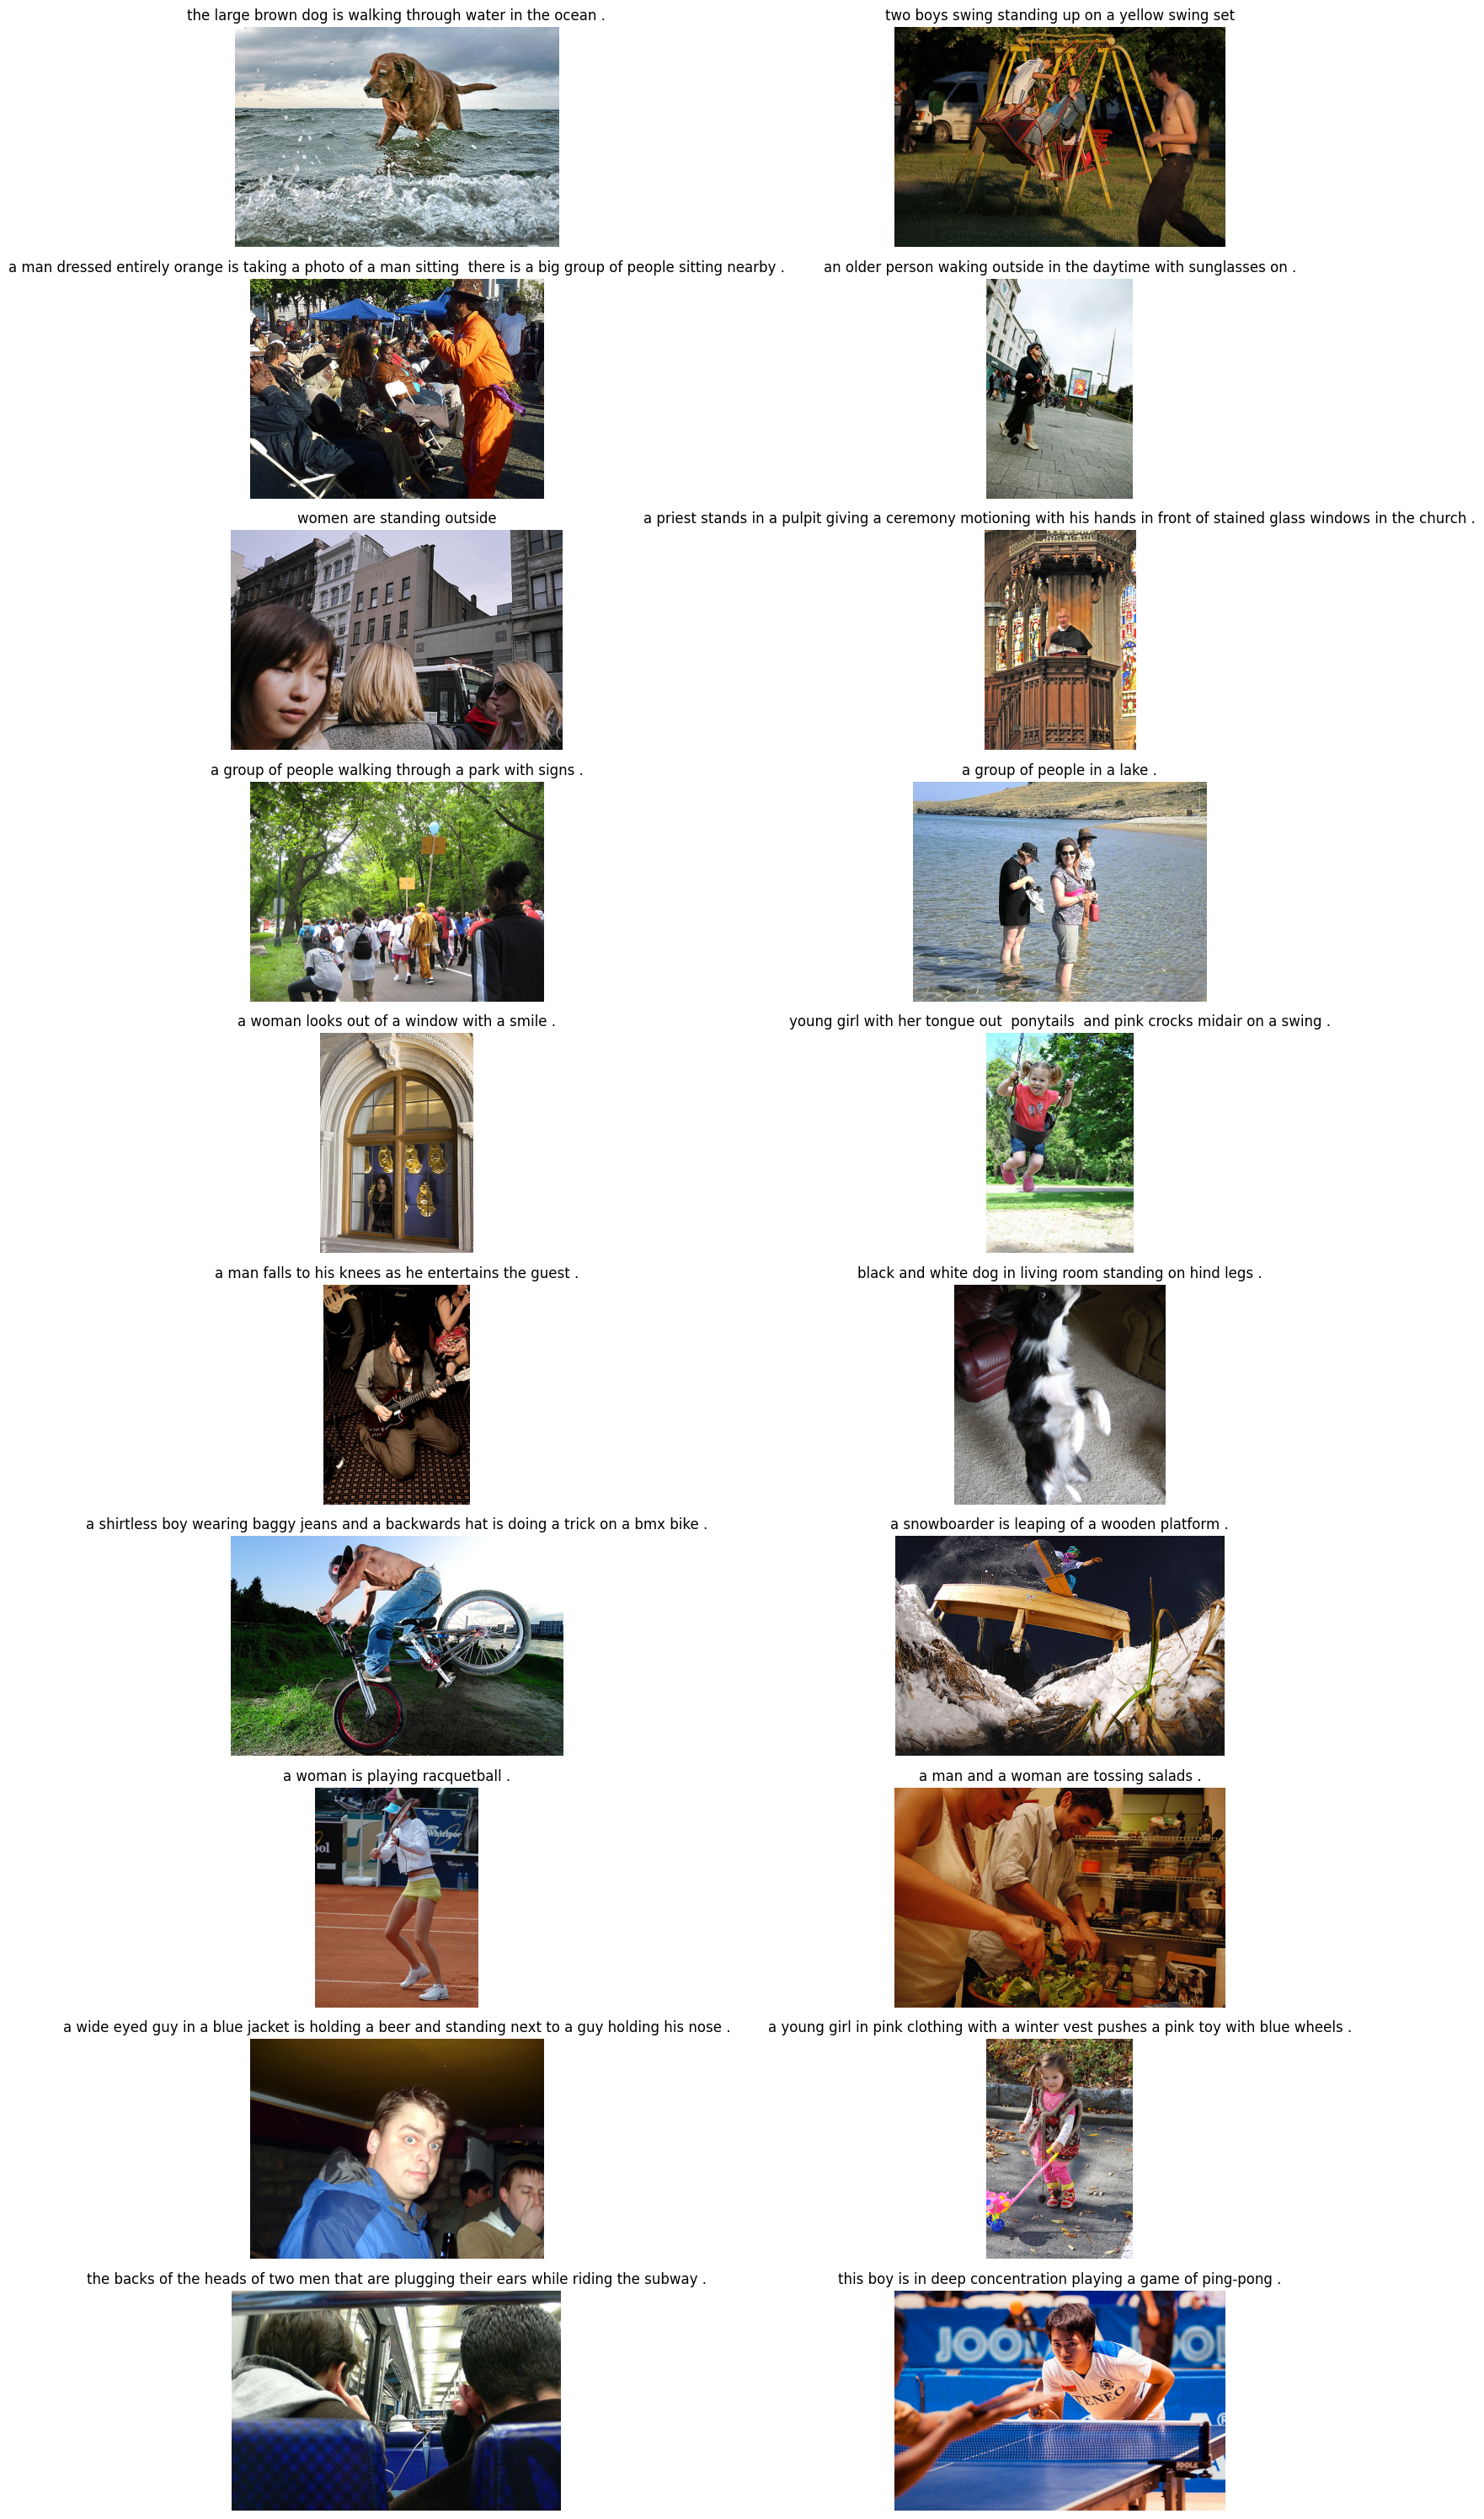

In [ ]:
sampled_df = df.sample(n=20)
fig, axs = plt.subplots(10, 2, figsize=(20, 30))

for i, row in enumerate(sampled_df.iterrows()):
    ax = axs[i // 2, i % 2]
    image_path = row[1]['image']
    caption = row[1]['caption']
    image = Image.open(image_path)
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(caption)

plt.tight_layout()
plt.show()

In [ ]:
train_df, val_df = train_test_split(df,test_size=0.1)
train_df.reset_index(drop=True,inplace=True)
val_df.reset_index(drop=True,inplace=True)
print(len(train_df),len(val_df))

143023 15892


In [ ]:
train_ds = Dataset(train_df,train_tfms)
val_ds = Dataset(val_df,valid_tfms)

In [ ]:
def collate_fn(batch):
    image = [i[0] for i in batch]
    input_ids = [i[1] for i in batch]
    labels = [i[2] for i in batch]
    image = torch.stack(image,dim=0)
    input_ids = tokenizer.pad(
        {'input_ids':input_ids},
        padding='longest',
        return_attention_mask=False,
        return_tensors='pt'
    )['input_ids']
    labels = tokenizer.pad(
        {'input_ids':labels},
        padding='longest',
        return_attention_mask=False,
        return_tensors='pt'
    )['input_ids']
    mask = (input_ids!=tokenizer.pad_token_id).long()
    labels[mask==0]=-100
    return image, input_ids, labels

In [ ]:
dl = torch.utils.data.DataLoader(train_ds,shuffle=True,batch_size=2,collate_fn=collate_fn)
_,c,l = next(iter(dl))
print(c[0])
print(l[0])

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


tensor([   64,  2415,   287,   257,  2042, 10147,   290, 12581,  2712,   262,
        38283,   329,   281,  5386,   764, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256])
tensor([ 2415,   287,   257,  2042, 10147,   290, 12581,  2712,   262, 38283,
          329,   281,  5386,   764, 50256,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100])


In [ ]:
class GPT2Attention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.n_heads = config.num_heads
        assert self.embed_dim % self.n_heads == 0, 'embedding dimension by be divisible by number of heads'
        self.head_size = self.embed_dim // self.n_heads
        self.seq_len = config.seq_len

        self.c_attn = nn.Linear(self.embed_dim, self.head_size * self.n_heads * 3,bias=True)
        self.scale = self.head_size ** -0.5

        self.register_buffer('mask',torch.tril(torch.ones(1,1,self.seq_len,self.seq_len)))

        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=True)

        self.attn_dropout = nn.Dropout(config.attention_dropout)
        self.resid_dropout = nn.Dropout(config.residual_dropout)


    def forward(self, x):
        b,t,c = x.shape
        # q,k,v shape individually: batch_size x seq_len x embed_dim
        # we know that qk_t = q x k_t, where q=bxtxhead_dim, k_t=bxhead_timxt
        q,k,v = self.c_attn(x).chunk(3,dim=-1)
        q = q.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3) # batch x n_heads x seq_len x head_dim
        k = k.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)
        v = v.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)

        qk_t = (q@k.transpose(-2,-1)) * self.scale
        qk_t = qk_t.masked_fill(self.mask[:,:,:t,:t]==0,float('-inf'))
        qk_t = F.softmax(qk_t,dim=-1)
        weights = self.attn_dropout(qk_t)

        attention = weights @ v # batch x n_heads x t x head_size
        attention = attention.permute(0,2,1,3).contiguous().view(b,t,c) # batch x t x embed_dim

        out = self.c_proj(attention)
        out = self.resid_dropout(out)

        return out

In [ ]:
class GPT2CrossAttention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.n_heads = config.num_heads
        assert self.embed_dim % self.n_heads == 0, 'embedding dimension by be divisible by number of heads'
        self.head_size = self.embed_dim // self.n_heads
        self.seq_len = config.seq_len

        self.q = nn.Linear(self.embed_dim,self.embed_dim)
        self.k = nn.Linear(self.embed_dim,self.embed_dim)
        self.v = nn.Linear(self.embed_dim,self.embed_dim)
        self.scale = self.head_size ** -0.5

        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=True)

        self.attn_dropout = nn.Dropout(config.attention_dropout)
        self.resid_dropout = nn.Dropout(config.residual_dropout)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)


    def forward(self, q,k,v):
        b,t,c = q.shape

        q = self.q(q)
        k = self.k(k)
        v = self.v(v)

        q = q.view(b,q.size(1),self.n_heads,self.head_size).permute(0,2,1,3) # batch x n_heads x seq_len x head_dim
        k = k.view(b,k.size(1),self.n_heads,self.head_size).permute(0,2,1,3)
        v = v.view(b,v.size(1),self.n_heads,self.head_size).permute(0,2,1,3)

        qk_t = (q@k.transpose(-2,-1)) * self.scale
        qk_t = F.softmax(qk_t,dim=-1)
        weights = self.attn_dropout(qk_t)

        attention = weights @ v # batch x n_heads x t x head_size
        attention = attention.permute(0,2,1,3).contiguous().view(b,t,c) # batch x t x embed_dim

        out = self.c_proj(attention)
        out = self.resid_dropout(out)

        return out

In [ ]:
class GPT2MLP(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.mlp_ratio = config.mlp_ratio
        self.mlp_dropout = config.mlp_dropout

        self.c_fc = nn.Linear(self.embed_dim,self.embed_dim*self.mlp_ratio)
        self.c_proj = nn.Linear(self.embed_dim*self.mlp_ratio,self.embed_dim)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(self.mlp_dropout)

    def forward(self,x):
        x = self.c_fc(x)
        x = self.act(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

In [ ]:
class GPT2Block(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.ln_1 = nn.LayerNorm(self.embed_dim)
        self.attn = GPT2Attention(config)
        self.ln_2 = nn.LayerNorm(self.embed_dim)
        self.mlp = GPT2MLP(config)
        self.ln_3 = nn.LayerNorm(self.embed_dim)
        self.cross_attn = GPT2CrossAttention(config)

    def forward(self,x,enc_out):
        x = x+self.attn(self.ln_1(x))
        x = x+self.cross_attn(self.ln_2(x),enc_out,enc_out)
        x = x+self.mlp(self.ln_3(x))
        return x

In [ ]:
class VisionGPT2Model(nn.Module):
    def __init__(self,config):
        super().__init__()

        self.config = config

        vit = create_model('vit_base_patch16_224',pretrained=True,num_classes=0)
        self.patch_embed = vit.patch_embed
        num_patches = self.patch_embed.num_patches

        self.cls_token = vit.cls_token
        embed_len = num_patches + vit.num_prefix_tokens
        self.pos_embed = vit.pos_embed
        self.pos_drop = nn.Dropout(p=0.)

        self.blocks = nn.ModuleList([vit.blocks[i] for i in range(config.depth)])

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size,config.embed_dim),
            wpe = nn.Embedding(config.seq_len,config.embed_dim),
            drop = nn.Dropout(config.emb_dropout),
            h = nn.ModuleList([GPT2Block(config) for _ in range(config.depth)]),
            ln_f = nn.LayerNorm(config.embed_dim)
        ))
        self.lm_head = nn.Linear(config.embed_dim,config.vocab_size,bias=False)
        self.transformer.wte.weight = self.lm_head.weight

    def _pos_embed(self,x):
        pos_embed = self.pos_embed
        x = torch.cat((self.cls_token.expand(x.shape[0], -1, -1), x), dim=1)
        x = x + pos_embed
        return self.pos_drop(x)

    def pretrained_layers_trainable(self,trainable=False):
        layers = [
            self.cls_token, self.patch_embed, self.pos_embed, self.blocks,
            self.transformer.wte, self.transformer.wpe,
            self.transformer.ln_f, self.lm_head
        ]
        gpt_layers = [[
            self.transformer.h[i].ln_1,self.transformer.h[i].ln_2,
            self.transformer.h[i].attn,self.transformer.h[i].mlp
        ] for i in range(self.config.depth)]
        for l in gpt_layers:
            layers.extend(l)

        for layer in layers:
            if not isinstance(layer,nn.Parameter):
                for p in layer.parameters():
                    p.requires_grad = trainable
            else:
                layer.requires_grad = trainable

        total_frozen_params = sum([p.numel() for p in self.parameters() if not p.requires_grad])
        print(f'{total_frozen_params=}')

    def unfreeze_gpt_layers(self,):
        gpt_layers = [[
            self.transformer.h[i].ln_1,self.transformer.h[i].ln_2,
            self.transformer.h[i].attn,self.transformer.h[i].mlp
        ] for i in range(self.config.depth)]
        flatten = []
        for l in gpt_layers:
            flatten.extend(l)

        for layer in flatten:
            if not isinstance(layer,nn.Parameter):
                for p in layer.parameters():
                    p.requires_grad = True
            else:
                layer.requires_grad = True

    @classmethod
    def from_pretrained(self,config):
        model = VisionGPT2Model(config)
        sd = model.state_dict()
        keys = sd.keys()
        ignore_matches = ['blocks.','cross_attn.','ln_3','cls_token','pos_embed','patch_embed.','.attn.mask']
        vit_keys = [key for key in keys if any(match in key for match in ignore_matches)]
        gpt_keys = [key for key in keys if key not in vit_keys]

        gpt2_small = GPT2LMHeadModel.from_pretrained('gpt2')
        sd_hf = gpt2_small.state_dict()
        hf_keys = sd_hf.keys()
        hf_keys = [k for k in hf_keys if not k.endswith('.attn.masked_bias')]
        hf_keys = [k for k in hf_keys if not k.endswith('.attn.bias')]
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']

        for k in hf_keys:
            if any(match in k for match in ignore_matches):
                continue
            if any(k.endswith(w) for w in transposed):
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        model.load_state_dict(sd)

        return model

    def forward(self,image,input_ids,labels=None):

        image = self.patch_embed(image)
        image = self._pos_embed(image)

        token_embeddings = self.transformer.wte(input_ids) # batch x seq_len
        pos_embs = torch.arange(0,input_ids.size(1)).to(input_ids.device)
        positional_embeddings = self.transformer.wpe(pos_embs)
        input_ids = self.transformer.drop(token_embeddings+positional_embeddings)

        for i in range(self.config.depth):
            image = self.blocks[i](image)
            input_ids = self.transformer.h[i](input_ids, image)

        input_ids = self.transformer.ln_f(input_ids)

        if labels is not None:
            lm_logits = self.lm_head(input_ids)
            loss = F.cross_entropy(lm_logits.view(-1, lm_logits.shape[-1]), labels.view(-1))
            return loss

        lm_logits = self.lm_head(input_ids[:,[-1],:])
        return lm_logits

    def generate(self,image,sequence,max_tokens=50,temperature=1.0,deterministic=False):
        for _ in range(max_tokens):
            out = self(image,sequence)
            out = out[:,-1,:] / temperature
            probs = F.softmax(out,dim=-1)
            if deterministic:
                next_token = torch.argmax(probs,dim=-1,keepdim=True)
            else:
                next_token = torch.multinomial(probs,num_samples=1)
            sequence = torch.cat([sequence,next_token],dim=1)
            if next_token.item() == tokenizer.eos_token_id:
                break

        return sequence.cpu().flatten()

In [ ]:
# !pip install rouge

In [ ]:
# from rouge import Rouge
# from nltk.translate.bleu_score import corpus_bleu
# from torchvision import transforms
# from torchvision.transforms import ToTensor

In [ ]:
# 모델 평가를 위한 함수 정의
from nltk.translate.bleu_score import corpus_bleu
import torch
from tqdm import tqdm

def evaluate_model(model, data_loader, tokenizer):
    model.eval()
    references = []
    hypotheses = []

    with torch.no_grad():
        for image, _, labels in tqdm(data_loader, total=len(data_loader)):
            generated_caption = generate_caption(model, image, tokenizer)
            references.append([tokenizer.decode(labels[i].tolist(), skip_special_tokens=True).split() for i in range(len(labels))])
            hypotheses.append(tokenizer.decode(generated_caption, skip_special_tokens=True).split())

    bleu_score = corpus_bleu(references, hypotheses)
    return bleu_score

In [ ]:
class Trainer:
    def __init__(self,model_config,train_config, dls):

        self.train_config = train_config
        self.model_config = model_config
        self.device = self.train_config.device

        self.model = VisionGPT2Model.from_pretrained(model_config).to(self.device)
        self.model.pretrained_layers_trainable(trainable=False)

        print(f'trainable parameters: {sum([p.numel() for p in self.model.parameters() if p.requires_grad])}')

        self.tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
        self.tokenizer.pad_token = self.tokenizer.eos_token

        self.scaler = GradScaler()

        self.train_dl, self.val_dl = dls

        total_steps = len(self.train_dl)

        self.optim = torch.optim.Adam(self.model.parameters(), lr=self.train_config.lr / 25.)
        self.sched = torch.optim.lr_scheduler.OneCycleLR(
            self.optim,
            max_lr=self.train_config.lr,
            epochs=self.train_config.epochs,
            steps_per_epoch=total_steps
        )

#         self.sched = get_linear_schedule_with_warmup(self.optim,num_warmup_steps=0,num_training_steps=total_steps)

        self.metrics = pd.DataFrame()
        self.metrics[['train_loss','train_perplexity','val_loss','val_perplexity']] = None

        self.gen_tfms = A.Compose([
            A.Resize(224,224),
            A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5],always_apply=True),
            ToTensorV2()
        ])


    def save_model(self,):
        self.train_config.model_path.mkdir(exist_ok=True)
        sd = self.model.state_dict()
        torch.save(sd,self.train_config.model_path/'captioner.pt')


    def load_best_model(self,):
        sd = torch.load(self.train_config.model_path/'captioner.pt')
        self.model.load_state_dict(sd)


    def train_one_epoch(self,epoch):

        prog = tqdm(self.train_dl,total=len(self.train_dl))

        running_loss = 0.

        for image, input_ids, labels in prog:

            with autocast():
                image = image.to(self.device)
                input_ids = input_ids.to(self.device)
                labels = labels.to(self.device)

                loss = self.model(image,input_ids,labels)

                self.scaler.scale(loss).backward()
                self.scaler.step(self.optim)
                self.scaler.update()
                self.sched.step()
                self.optim.zero_grad(set_to_none=True)

                running_loss += loss.item()

                prog.set_description(f'train loss: {loss.item():.3f}')

            del image, input_ids, labels, loss

        train_loss = running_loss / len(self.train_dl)
        train_pxp = np.exp(train_loss)

        self.metrics.loc[epoch,['train_loss','train_perplexity']] = (train_loss,train_pxp)


    @torch.no_grad()
    def valid_one_epoch(self,epoch):

        prog = tqdm(self.val_dl,total=len(self.val_dl))

        running_loss = 0.

        for image, input_ids, labels in prog:

            with autocast():
                image = image.to(self.device)
                input_ids = input_ids.to(self.device)
                labels = labels.to(self.device)

                loss = self.model(image,input_ids,labels)
                running_loss += loss.item()

                prog.set_description(f'valid loss: {loss.item():.3f}')

            del image, input_ids, labels, loss

        val_loss = running_loss / len(self.val_dl)
        val_pxp = np.exp(val_loss)

        self.metrics.loc[epoch,['val_loss','val_perplexity']] = (val_loss,val_pxp)

        return val_pxp


    def clean(self):
        gc.collect()
        torch.cuda.empty_cache()


    def fit(self,):

        best_pxp = 1e9
        best_epoch = -1
        prog = tqdm(range(self.train_config.epochs))

        for epoch in prog:

            if epoch == self.train_config.freeze_epochs_gpt:
                self.model.unfreeze_gpt_layers()
                print('unfreezing GPT2 entirely...')

            if epoch == self.train_config.freeze_epochs_all:
                self.model.pretrained_layers_trainable(trainable=True)

            self.model.train()
            prog.set_description('training')
            self.train_one_epoch(epoch)
            self.clean()

            self.model.eval()
            prog.set_description('validating')
            pxp = self.valid_one_epoch(epoch)
            self.clean()

            print(self.metrics.tail(1))

            if pxp < best_pxp:
                best_pxp = pxp
                best_epoch = epoch
                print('saving best model...')
                self.save_model()

        return {
            'best_perplexity': best_pxp,
            'best_epoch': best_epoch
        }


    @torch.no_grad()
    def generate_caption(self,image,max_tokens=50,temperature=1.0,deterministic=False):

        self.model.eval()

        image = Image.open(image).convert('RGB')
        image = np.array(image)
        image = self.gen_tfms(image=image)['image']
        image = image.unsqueeze(0).to(self.device)
        sequence = torch.ones(1,1).to(device=self.device).long() * self.tokenizer.bos_token_id

        caption = self.model.generate(
            image,
            sequence,
            max_tokens=max_tokens,
            temperature=temperature,
            deterministic=deterministic
        )
        caption = self.tokenizer.decode(caption.numpy(),skip_special_tokens=True)

        return caption

In [ ]:
model_config = SimpleNamespace(
    vocab_size = 50_257,
    embed_dim = 768,
    num_heads = 12,
    seq_len = 1024,
    depth = 12,
    attention_dropout = 0.1,
    residual_dropout = 0.1,
    mlp_ratio = 4,
    mlp_dropout = 0.1,
    emb_dropout = 0.1,
)
train_config = SimpleNamespace(
    epochs = 5,
    freeze_epochs_gpt = 1,
    freeze_epochs_all = 2,
    lr = 1e-4,
    device = 'cuda',
    model_path = Path('captioner'),
    batch_size = 32
)

In [ ]:
train_dl = torch.utils.data.DataLoader(train_ds,batch_size=train_config.batch_size,shuffle=True,pin_memory=True,num_workers=2,persistent_workers=True,collate_fn=collate_fn)
val_dl = torch.utils.data.DataLoader(val_ds,batch_size=train_config.batch_size,shuffle=False,pin_memory=True,num_workers=2,persistent_workers=True,collate_fn=collate_fn)

In [ ]:
trainer = Trainer(model_config,train_config,(train_dl,val_dl))

In [ ]:
trainer.fit()

Streaming output truncated to the last 5000 lines.
valid loss: 3.127: 100%|██████████| 497/497 [00:45<00:00, 10.89it/s]


  train_loss train_perplexity  val_loss val_perplexity
0   5.299477       200.232133  3.555988      35.022411
saving best model...


training:  20%|██        | 1/5 [12:45<51:01, 765.35s/it]  

unfreezing GPT2 entirely...



train loss: 2.959:  43%|████▎     | 1937/4470 [05:14<06:56,  6.08it/s]

In [ ]:
# 모델 평가
bleu_score = evaluate_model(trainer.model, trainer.val_dl, trainer.tokenizer)
print(f"BLEU Score: {bleu_score}")

In [ ]:
trainer.metrics

In [ ]:
plt.plot(trainer.metrics['train_loss'],color='red',label='train loss')
plt.plot(trainer.metrics['val_loss'],color='orange',label='valid loss')
plt.title('loss, lower=better')
plt.legend()
plt.show()

In [ ]:
plt.plot(trainer.metrics['train_perplexity'],color='blue',label='train perplexity')
plt.plot(trainer.metrics['val_perplexity'],color='lightblue',label='valid perplexity')
plt.title('perplexity, lower=better')
plt.legend()
plt.show()

In [ ]:
trainer.metrics['bleu_score'] = [bleu_1, bleu_2, ...] # BLEU score 저장
trainer.metrics['rouge_score'] = [rouge_1, rouge_2, ...] # ROUGE score 저장

plt.plot(trainer.metrics['train_perplexity'], color='blue', label='train perplexity')
plt.plot(trainer.metrics['val_perplexity'], color='lightblue', label='valid perplexity')

plt.plot(trainer.metrics['bleu_score'], color='green', label='bleu score')
plt.plot(trainer.metrics['rouge_score'], color='orange', label='rouge score')

plt.title('Evaluation Metrics')
plt.legend()
plt.show()

In [ ]:
trainer.calculate_bleu_score()

In [ ]:
trainer.load_best_model()

In [ ]:
for i in range(50):
    det = False
    test = val_df.sample(n=1).values[0]
    test_img, test_caption = test[0],test[1]
    plt.imshow(Image.open(test_img).convert('RGB'))
    t = np.random.uniform(0.5,1.5)
    if i > 40:
        det = True
    gen_caption = trainer.generate_caption(test_img,temperature=t,deterministic=det)
    plt.title(f"actual: {test_caption}\nmodel: {gen_caption}\ntemp: {t} deterministic generation: {det}")
    plt.axis('off')
    plt.show()

In [ ]:
# !pip install --upgrade torchtext

In [ ]:
# Build vocabs
token_transform = get_tokenizer('basic_english')

def yield_tokens(data_iter):
    for data_sample in data_iter:
        yield token_transform(data_sample)

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

In [ ]:
vocab_transform = build_vocab_from_iterator(yield_tokens(df['comment']),
                                                min_freq = 4,
                                                specials = special_symbols,
                                                special_first=True)
vocab_transform.set_default_index(UNK_IDX)

TypeError: ignored

In [ ]:
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

def tensor_transform(token_ids):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

text_transform = sequential_transforms(token_transform, #Encode
                                        vocab_transform, #Numericalization
                                        tensor_transform) # Add BOS/EOS and create tensor

In [ ]:
class ImageCaptionDataset(Dataset):
    def __init__(self, df = df, transform = None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index= index.tolist()

        img_path = os.path.join('/kaggle/input/flickr30k/flickr30k_images', self.df.iloc[index, 0])
        caption = self.df.iloc[index, 1]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        #numericalize the caption text
        caption_vec = text_transform(caption.rstrip("\n"))

        return img, caption_vec

In [ ]:
def collate_fn(batch):
    imgs = [item[0].unsqueeze(0) for item in batch]
    captions = [item[1] for item in batch]

    imgs = torch.cat(imgs,dim=0)
    captions = pad_sequence(captions,
                            batch_first = True,
                            padding_value=PAD_IDX)
    return imgs, captions

In [ ]:
transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),                           # convert the PIL Image to a tensor
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

train_dataset = ImageCaptionDataset(df = df,
                                    transform = transform)

In [ ]:
train_loader = DataLoader(train_dataset,
                          batch_size=64,
                          num_workers=2,
                          shuffle=True,
                          pin_memory=True,
                          collate_fn=collate_fn)

In [ ]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class LSA(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.temperature = nn.Parameter(torch.log(torch.tensor(dim_head ** -0.5)))

        self.norm = nn.LayerNorm(dim)
        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = self.norm(x)
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.temperature.exp()

        mask = torch.eye(dots.shape[-1], device = dots.device, dtype = torch.bool)
        mask_value = -torch.finfo(dots.dtype).max
        dots = dots.masked_fill(mask, mask_value)

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class TransformerEncoder(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                LSA(dim, heads = heads, dim_head = dim_head, dropout = dropout),
                FeedForward(dim, mlp_dim, dropout = dropout)
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class SPT(nn.Module):
    def __init__(self, dim, patch_size, channels = 3):
        super().__init__()
        patch_dim = patch_size * patch_size * 5 * channels

        self.to_patch_tokens = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim)
        )

    def forward(self, x):
        shifts = ((1, -1, 0, 0), (-1, 1, 0, 0), (0, 0, 1, -1), (0, 0, -1, 1))
        shifted_x = list(map(lambda shift: F.pad(x, shift), shifts))
        x_with_shifts = torch.cat((x, *shifted_x), dim = 1)
        return self.to_patch_tokens(x_with_shifts)

class ViT(nn.Module):
    def __init__(self, image_size, patch_size, dim, depth, heads, mlp_dim,
                 channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width

        self.to_patch_embedding = SPT(dim = dim, patch_size = patch_size, channels = channels)

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = TransformerEncoder(dim, depth, heads, dim_head, mlp_dim, dropout)

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        return x

In [ ]:
# helper Module represent positional encoding
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float = 0.1,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()

        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

class Decoder(nn.Module):
    __constants__ = ['norm']

    def __init__(self, dim, num_head, num_layers, norm=None):
        super().__init__()
        decoder_layer = TransformerDecoderLayer(d_model=dim, nhead=num_head, batch_first = True)
        torch._C._log_api_usage_once(f"torch.nn.modules.{self.__class__.__name__}")
        self.layers = nn.ModuleList([copy.deepcopy(decoder_layer) for i in range(num_layers)])
        self.num_layers = num_layers
        self.norm = norm

    def forward(self, tgt, memory, tgt_mask = None,
                memory_mask = None, tgt_key_padding_mask = None,
                memory_key_padding_mask = None):

        output = tgt

        for mod in self.layers:
            output = mod(output, memory, tgt_mask=tgt_mask,
                         memory_mask=memory_mask,
                         tgt_key_padding_mask=tgt_key_padding_mask,
                         memory_key_padding_mask=memory_key_padding_mask)

        if self.norm is not None:
            output = self.norm(output)

        return output

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, image_size, patch_size, dim, num_layer,
                 num_head, num_classes, mlp_dim, dropout, emb_dropout):
        super().__init__()

        self.encoder = ViT(
            image_size = image_size,
            patch_size = patch_size,
            dim = dim,
            depth = num_layer,
            heads = num_head,
            mlp_dim = mlp_dim,
            dropout = dropout,
            emb_dropout = emb_dropout
        )

        self.decoder = Decoder(
            dim = dim,
            num_head = num_head,
            num_layers = num_layer
        )
        self.tok_emb = TokenEmbedding(num_classes, dim)
        self.positional_encoding = PositionalEncoding(
            dim, dropout=dropout)
        self.generator = nn.Linear(dim, num_classes)

    @staticmethod
    def generate_square_subsequent_mask(sz, device='cpu'):
        r"""Generate a square mask for the sequence. The masked positions are filled with float('-inf').
            Unmasked positions are filled with float(0.0).
        """
        return torch.triu(torch.full((sz, sz), float('-inf'), device=device), diagonal=1)

    def forward(self, img, caption, cap_mask, cap_padding_mask):
        memory = self.encoder(img)
        cap_emb = self.positional_encoding(self.tok_emb(caption))
        outs = self.decoder(cap_emb, memory, tgt_mask = cap_mask, tgt_key_padding_mask = cap_padding_mask)

        return self.generator(outs) #(batch, seq_length, num_classes)

    def encode(self, img):
        return self.encoder(img)

    def decode(self, caption, memory, cap_mask):
        return self.decoder(self.positional_encoding(self.tok_emb(caption)), memory,
                            tgt_mask = cap_mask)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(cap):
    tgt_seq_len = cap.shape[1]

    cap_mask = generate_square_subsequent_mask(tgt_seq_len)
    cap_padding_mask = (cap == PAD_IDX)

    return cap_mask, cap_padding_mask

In [ ]:
torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Hyperparams
image_size = 224
patch_size = 16
dim = 512
num_layer = 6
num_head = 8
vocab_size = len(vocab_transform)
mlp_dim = 1024
dropout = 0.1
emb_dropout = 0.1

#init model
model = Seq2Seq(
    image_size = image_size,
    patch_size = patch_size,
    dim = dim,
    num_layer = num_layer,
    num_head = num_head,
    num_classes = vocab_size,
    mlp_dim = mlp_dim,
    dropout = dropout,
    emb_dropout = emb_dropout
)
#init weights

model = model.to(device)

In [ ]:
learning_rate = 5e-5
clip_norm = 5

criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)

In [ ]:
def train_batch(model, image, captions, optimizer, criterion, device):
    model.train()

    image,captions = image.to(device),captions.to(device)
    # Zero the gradients.
    optimizer.zero_grad()
    # Remove EOS idx
    tgt_input = captions[:, :-1]
    # Create mask
    cap_mask, padding_mask = create_mask(tgt_input)
    # Feed forward
    outputs = model(image, tgt_input, cap_mask = cap_mask, cap_padding_mask = padding_mask)

    # Calculate the batch loss.
    # Remove BOS idx
    tgt_out = captions[:, 1:]
    loss = criterion(outputs.view(-1, outputs.size(-1)), tgt_out.reshape(-1))

    iteration_loss = loss.item()

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
    optimizer.step()

    return iteration_loss

In [ ]:
print('TRAINING PROCESS:')
print('-'*100)
NUM_EPOCHS = 15
i = 1
epoch_losses = []
val_losses = []
iteration_losses = []
num_updates_epochs = []

valid_every = 5
show_interval = 1250
best_valid_loss = float('inf')

for epoch in range(1, NUM_EPOCHS+1):
    print(f"Epoch {epoch}/{NUM_EPOCHS}: ")
    epoch_loss_list = []

    for image, captions in tqdm(train_loader, leave=False):
        iteration_loss = train_batch(model, image, captions, optimizer, criterion, device)
        iteration_losses.append(iteration_loss)
        epoch_loss_list.append(iteration_loss)

        if i % show_interval == 0:
            print('Train batch loss[',i, ']: ', np.mean(epoch_loss_list))
        i += 1

    epoch_loss = np.mean(epoch_loss_list)
    print("--> Train epoch {} loss: {}".format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

In [ ]:
# function to generate output sequence using greedy algorithm
def greedy_search(model, img, max_len = 32, start_symbol = BOS_IDX):
    img = img.to(device)

    img_enc = model.encode(img).to(device)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)

    for i in range(max_len):
        cap_mask = model.generate_square_subsequent_mask(ys.size(1), device = device)
        out = model.decode(ys, img_enc, cap_mask)


        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)

        next_word = next_word.item()
        # Concat res by seq len
        ys = torch.cat([ys,torch.ones(1, 1).type_as(ys.data).fill_(next_word)], dim=1)

        if next_word == EOS_IDX:
                break
    return ys
    #return ' '.join(vocab_transform.lookup_tokens(list(ys.flatten().cpu().numpy())))

def inference(model, path, max_len = 12, start_symbol = BOS_IDX):
    model.eval()
    img = Image.open(path).convert("RGB")
    img = transform(img).unsqueeze(0)
    tgt_tokens = greedy_search(model, img, max_len = max_len, start_symbol = start_symbol).flatten()
    return ' '.join(vocab_transform.lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>","").replace("<eos>","")

In [ ]:
from random import randint
import matplotlib.pyplot as plt

rand = [randint(0, 150000) for i in range(5)]


for i in rand:
    ele = df.iloc[i]
    plt.figure(figsize=(20, 10))
    image_path = "/kaggle/input/flickr30k/flickr30k_images/" + ele[0]
    img = Image.open(image_path)
    plt.imshow(img)
    plt.xlabel('Predicted Caption:' + inference(model, image_path, max_len = 24, start_symbol = BOS_IDX)
              + '\n' + 'Actual Caption:' + ele[1])